## Phenology NDVI

Computes Normalized Difference Vegetation Index (NDVI). Used to determine if a cell contains live green vegetation.

The focus of this notebook is to analyse information for each pixel based on its focal neighborhood kernel. The xrspatial.focal provides a set of analysis tools performing neighborhood operations and NDVI aggregration.

In [1]:
import planetary_computer as pc

import numpy as np
import xarray as xr

import stackstac
import pystac_client

import matplotlib.pyplot as plt

import geopandas as gpd
import json
import rasterio.features
from pystac.extensions.projection import ProjectionExtension as proj

import xrspatial.multispectral as ms
from xrspatial.convolution import calc_cellsize, circle_kernel, convolution_2d
from xrspatial.focal import mean, focal_stats, hotspots

from dask.distributed import Client, progress

### Local Dask Cluster

We'll use a small number of images for this example. We'll parallelize reading the data from Azure Blob Storage using a local Dask "cluster" on this single machine.

In [2]:
client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


You can access the Dask Dashboard by pasting that URL into the Dask labextension field. See [Scale with Dask](../quickstarts/scale-with-dask.ipynb) for more.

### Data

In [3]:
#select country
local =  gpd.read_file('fiji_tavua.geojson')
area_of_interest = local.geometry[0]

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

search = catalog.search(
    intersects=area_of_interest,
    datetime="2016-01-01/2022-03-30",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 10}}, #cloudcover_percentage
)

In [4]:
items = [pc.sign(item).to_dict() for item in search.get_items()]
print(len(items))

60


Now we'll sign the STAC items so we can download the data from blob storage. See [Using Tokens for Data Access](../concepts/sas.ipynb) for more. 

In [5]:
item = next(search.get_items())
epsg = proj.ext(item).epsg

data = (
    stackstac.stack(
        items,
        epsg=epsg,
        resolution=500, #resolution/m
        assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        chunksize=8192, #4096, #256,  # set chunk size to 256 to get one chunk per time step
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        band=lambda x: x.common_name.rename("band"),  # use common names
        time=lambda x: x.time.dt.round(
            "D"
        ),  # round time to daily for nicer plot labels
    )
)

#downsample to monthly
data = data.resample(time="6MS").median("time", keep_attrs=True)
#data = data.resample(time="1Y").median("time", keep_attrs=True)

data

<xarray.DataArray 'stackstac-e0e41308aad0f888ae2734330a76b863' (time: 13, band: 4, y: 221, x: 221)>
dask.array<stack, shape=(13, 4, 221, 221), dtype=float64, chunksize=(1, 1, 221, 221), chunktype=numpy.ndarray>
Coordinates:
  * time                                     (time) datetime64[ns] 2016-01-01...
  * band                                     (band) <U5 'blue' 'green' ... 'nir'
  * x                                        (x) float64 4.995e+05 ... 6.095e+05
  * y                                        (y) float64 8.100e+06 ... 7.990e+06
    s2:product_type                          <U7 'S2MSI2A'
    sat:relative_orbit                       int64 72
    constellation                            <U10 'Sentinel 2'
    sat:orbit_state                          <U10 'descending'
    s2:saturated_defective_pixel_percentage  float64 0.0
    proj:epsg                                int64 32760
    instruments                              <U3 'msi'
    s2:datatake_type                         <U8 'INS-NOBS'
    s2:mgrs_tile                             <U5 '60KWF'
    title                                    (band) <U20 'Band 2 - Blue - 10m...
    proj:transform                           object {0.0, 8100040.0, 10.0, 49...
    gsd                                      int64 10
    proj:bbox                                object {7990240.0, 609780.0, 499...
    proj:shape                               object {10980}
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int64 32760
Attributes:
    spec:        RasterSpec(epsg=32760, bounds=(499500, 7990000, 610000, 8100...
    crs:         epsg:32760
    transform:   | 500.00, 0.00, 499500.00|\n| 0.00,-500.00, 8100500.00|\n| 0...
    resolution:  500

In [6]:
#data = data.persist()
#progress(data)

### NDVI

NDVI can be calculated with [xarray-spatial](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.ndvi.html). 

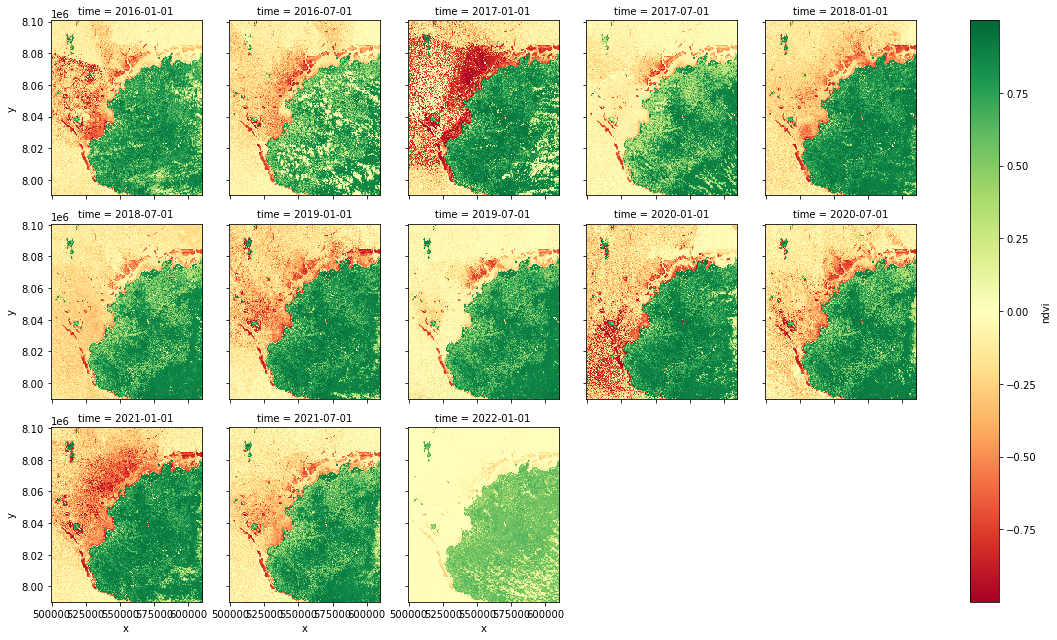

In [7]:
ndvi_aggs = [ms.ndvi(x.sel(band="nir"), x.sel(band="red")) for x in data]

ndvi = xr.concat(ndvi_aggs, dim="time")

ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="RdYlGn"); #RdYlGn #viridis

### Smoothing Images with Focal Mean

[`focal.mean`](https://xarray-spatial.org/reference/_autosummary/xrspatial.focal.mean.html) can be used to smooth or reduce noises in an image by a mean reduction to each 3x3 window in an image.

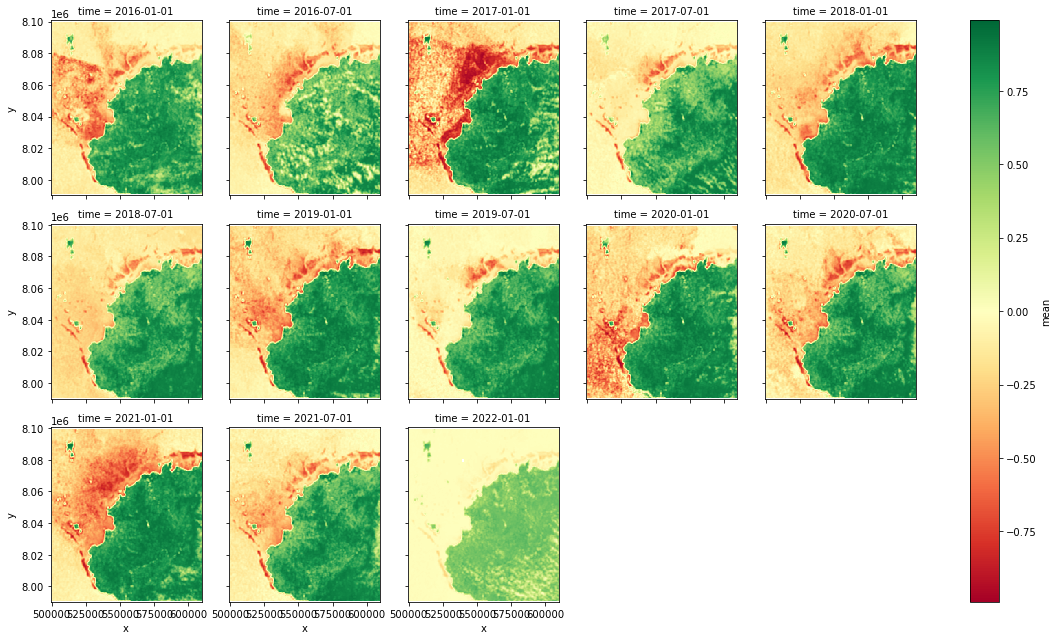

In [8]:
mean_aggs = [mean(ndvi_agg) for ndvi_agg in ndvi_aggs]

smooth = xr.concat(mean_aggs, dim="time")

s = smooth.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="RdYlGn") #RdYlGn #viridis

(array([  2391.,  10670.,  31963.,  83588., 160856.,  33612.,  11448.,
         41965.,  92426., 148884.]),
 array([-0.9899609 , -0.79566814, -0.60137538, -0.40708261, -0.21278985,
        -0.01849709,  0.17579567,  0.37008844,  0.5643812 ,  0.75867396,
         0.95296672]),
 <BarContainer object of 10 artists>)

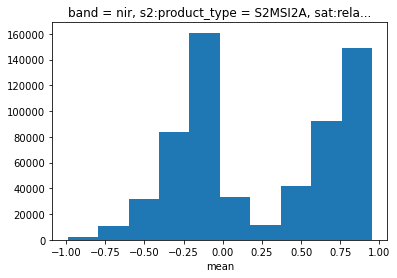

In [9]:
smooth.plot()

### Charting

In [20]:
smooth

<xarray.DataArray 'mean' (time: 13, y: 221, x: 221)>
dask.array<concatenate, shape=(13, 221, 221), dtype=float64, chunksize=(1, 221, 221), chunktype=numpy.ndarray>
Coordinates:
  * time                                     (time) datetime64[ns] 2016-01-01...
    band                                     <U5 'nir'
  * x                                        (x) float64 4.995e+05 ... 6.095e+05
  * y                                        (y) float64 8.100e+06 ... 7.990e+06
    s2:product_type                          <U7 'S2MSI2A'
    sat:relative_orbit                       int64 72
    constellation                            <U10 'Sentinel 2'
    sat:orbit_state                          <U10 'descending'
    s2:saturated_defective_pixel_percentage  float64 0.0
    proj:epsg                                int64 32760
    instruments                              <U3 'msi'
    s2:datatake_type                         <U8 'INS-NOBS'
    s2:mgrs_tile                             <U5 '60KWF'
    title                                    <U20 'Band 8 - NIR - 10m'
    proj:transform                           object {0.0, 8100040.0, 10.0, 49...
    gsd                                      int64 10
    proj:bbox                                object {7990240.0, 609780.0, 499...
    proj:shape                               object {10980}
    common_name                              <U5 'nir'
    center_wavelength                        float64 0.842
    full_width_half_max                      float64 0.145
    epsg                                     int64 32760
Attributes:
    spec:        RasterSpec(epsg=32760, bounds=(499500, 7990000, 610000, 8100...
    crs:         epsg:32760
    transform:   | 500.00, 0.00, 499500.00|\n| 0.00,-500.00, 8100500.00|\n| 0...
    resolution:  500

In [11]:
type(smooth)

xarray.core.dataarray.DataArray

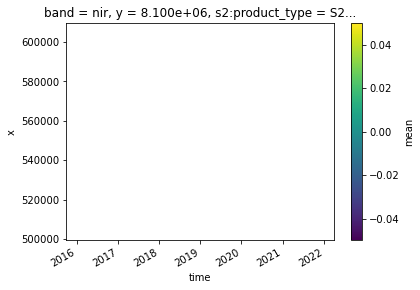

In [21]:
#smooth[:, 0].plot(x="time")

### Write Out COG tiles and Upload as Azure Blobs
Pending...
